[베이스라인 코드](https://dacon.io/competitions/official/236336/codeshare) 참고


#### 질문사항

- train.csv를 `Assay ChEMBL ID`, `Fingerprint`, `IC50_nM` 세 colmun만 남도록 정리했는데, test.csv에는 ChEMBL ID 관련 column이 따로 없고 `Smiles`와 `IC50_nM`만 있어서 모델을 test.csv에 적용하기 어려울 것 같습니다.

- GMF를 돌려보려 하니 `ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).`가 발생하여 15번 셀과 같이 수정했는데, 확인을 부탁드리고 싶습니다.

# Import

In [1]:
!pip install rdkit

In [2]:
import pandas as pd
import numpy as np
import os
import random

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split

In [3]:
CFG = {
    'NBITS':2048,
    'SEED':42,
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

# Dataset: ChEMBL & Smiles

### DataLoad

In [5]:
# SMILES 데이터를 분자 지문으로 변환
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        generator = Chem.rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=CFG['NBITS'])
        fp = generator.GetFingerprint(mol)
        return np.array(fp)
    else:
        return np.zeros((CFG['NBITS'],))

In [6]:
# 학습 ChEMBL 데이터 로드
chembl_data = pd.read_csv('train.csv')
chembl_data.loc[:, 'Fingerprint'] = chembl_data['Smiles'].apply(smiles_to_fingerprint)
chembl_data.head()

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,IC50_nM,pIC50,Smiles,Fingerprint
0,CHEMBL4443947,IC50,'=',0.022,nM,10.66,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,CHEMBL4556091,IC50,'=',0.026,nM,10.59,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,CHEMBL4566431,IC50,'=',0.078,nM,10.11,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,CHEMBL4545898,IC50,'=',0.081,nM,10.09,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,CHEMBL4448950,IC50,'=',0.099,nM,10.00,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
num_chembl = len(chembl_data['Assay ChEMBL ID'].unique())
num_smiles = len(chembl_data['Smiles'].unique())

print('Number of Assay ChEMBL IDs', num_chembl)
print('Number of Smiles', num_smiles)

Number of Assay ChEMBL IDs 72
Number of Smiles 1952


### Data Pre-processing

In [8]:
dataset = chembl_data[['Assay ChEMBL ID', 'Fingerprint', 'IC50_nM']].copy()

# assay chembl id 정수 변환
dataset['Assay ChEMBL ID'] = dataset['Assay ChEMBL ID'].str.extract('(\d+)', expand=False).astype(int)

# 열 이름 변경
dataset.rename(columns={'Assay ChEMBL ID': 'chembl_id', 'Fingerprint': 'fp'}, inplace=True)
dataset.head()

,chembl_id,fp,IC50_nM
0,4361896,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0.022
1,4345131,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0.026
2,4345131,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0.078
3,4345131,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0.081
4,4361896,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.099


In [9]:
train, test = train_test_split(dataset, test_size=0.2)

In [10]:
train.head()

,chembl_id,fp,IC50_nM
535,4625630,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.7
1651,3887963,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",640.0
1412,4689491,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",160.0
926,3887118,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",13.3
1928,3887893,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8300.0


In [11]:
test.head()

,chembl_id,fp,IC50_nM
1615,3887893,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",541.0
1406,3887893,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",150.0
1906,3887963,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6516.0
1580,3887893,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",450.0
307,3887118,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",2.7


# Generalized Matrix Factorization (GMF)

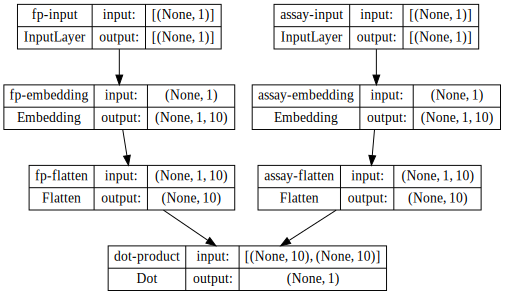

In [16]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dot
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

# Let's use a higher latent dimension.
latent_dim = 10

fp_input = Input(shape=[1], name='fp-input')
fp_embedding = Embedding(num_smiles + 1, latent_dim, name='fp-embedding')(fp_input)
fp_vec = Flatten(name='fp-flatten')(fp_embedding)

assay_input = Input(shape=[1],name='assay-input')
assay_embedding = Embedding(num_chembl + 1, latent_dim, name='assay-embedding')(assay_input)
assay_vec = Flatten(name='assay-flatten')(assay_embedding)

prod = Dot(axes=1, name='dot-product')([fp_vec, assay_vec])

model = Model([assay_input, fp_input], prod)
model.compile('adam', 'mean_squared_error')

# Adjust DPI to reduce SVG size
dot = model_to_dot(model, show_shapes=True, dpi=70)

# Create SVG with adjusted size
svg = SVG(dot.create(prog='dot', format='svg'))

display(svg)

In [17]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 fp-input (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 assay-input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 fp-embedding (Embedding)       (None, 1, 10)        19530       ['fp-input[0][0]']               
                                                                                                  
 assay-embedding (Embedding)    (None, 1, 10)        730         ['assay-input[0][0]']            
                                                                                            

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

history = model.fit([train.chembl_id, train.fp], train.IC50_nM, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.chembl_id, test.fp]), decimals=2)
y_true = test.IC50_nM
mean_absolute_error(y_true, y_hat)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

Epoch 1/10
49/49 [==============================] - 2s 14ms/step - loss: 278047358976.0000 - val_loss: 131089612800.0000
Epoch 2/10
49/49 [==============================] - 0s 5ms/step - loss: 67249123328.0000 - val_loss: 22974586880.0000
Epoch 3/10
49/49 [==============================] - 0s 5ms/step - loss: 9218792448.0000 - val_loss: 1745563264.0000
Epoch 4/10
49/49 [==============================] - 0s 5ms/step - loss: 510592864.0000 - val_loss: 36830752.0000
Epoch 5/10
49/49 [==============================] - 0s 5ms/step - loss: 14100288.0000 - val_loss: 4447575.0000
Epoch 6/10
49/49 [==============================] - 0s 6ms/step - loss: 7822211.5000 - val_loss: 4429256.5000
Epoch 7/10
49/49 [==============================] - 0s 5ms/step - loss: 7821008.5000 - val_loss: 4422085.5000
Epoch 8/10
49/49 [==============================] - 0s 6ms/step - loss: 7817875.5000 - val_loss: 4421889.5000
Epoch 9/10
49/49 [==============================] - 0s 6ms/step - loss: 7816503.5000 - val_

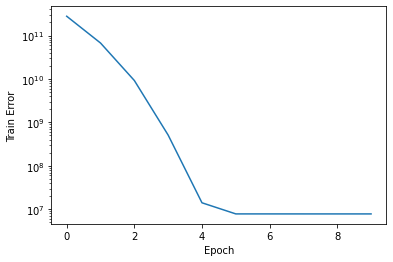

13/13 [==============================] - 0s 2ms/step
Mean Absolute Error: 879.5725708007812


In [15]:
X_train_fp = np.stack(train['fp'].values).astype(np.float32)
X_test_fp = np.stack(test['fp'].values).astype(np.float32)
X_train_chembl_id = train['chembl_id'].values.reshape(-1, 1).astype(np.float32)
X_test_chembl_id = test['chembl_id'].values.reshape(-1, 1).astype(np.float32)
y_train = train['IC50_nM'].values.astype(np.float32)
y_test = test['IC50_nM'].values.astype(np.float32)

from keras.layers import Dense, Concatenate

# 입력 정의
input_fp = Input(shape=(CFG['NBITS'],), name='fingerprint')
input_chembl_id = Input(shape=(1,), name='chembl_id')

# Fingerprint 처리
fp_layer = Dense(64, activation='relu')(input_fp)

# chembl_id 처리
chembl_id_layer = Dense(4, activation='relu')(input_chembl_id)

# 두 입력을 결합
merged = Concatenate()([fp_layer, chembl_id_layer])
output = Dense(1)(merged)

# 모델 정의
model = Model(inputs=[input_fp, input_chembl_id], outputs=output)

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 훈련
history = model.fit(
    [X_train_fp, X_train_chembl_id], y_train, 
    epochs=10, validation_data=([X_test_fp, X_test_chembl_id], y_test)
)

# 학습 결과 시각화
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

# 예측 및 평가
y_hat = np.round(model.predict([X_test_fp, X_test_chembl_id]), decimals=2)
y_true = y_test
mae = mean_absolute_error(y_true, y_hat)
print(f'Mean Absolute Error: {mae}')

# Evaluation & Submission

In [ ]:
"""def pIC50_to_IC50(pic50_values):
    return 10 ** (9 - pic50_values)

# Validation 데이터로부터의 학습 모델 평가
val_y_pred = model.predict(val_x)
mse = mean_squared_error(pIC50_to_IC50(val_y), pIC50_to_IC50(val_y_pred))
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')"""

### Inference

In [ ]:
"""test = pd.read_csv('./test.csv')
test['Fingerprint'] = test['Smiles'].apply(smiles_to_fingerprint)

test_x = np.stack(test['Fingerprint'].values)

test_y_pred = model.predict(test_x)"""

### Submission

In [ ]:
"""submit = pd.read_csv('./sample_submission.csv')
submit['IC50_nM'] = pIC50_to_IC50(test_y_pred)
submit.head()"""

In [ ]:
"""submit.to_csv('./baseline_submit.csv', index=False)"""